In [99]:
# dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from flask import Flask

# Reflect Tables into SQLAlchemy ORM

In [100]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [101]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [102]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [103]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [104]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [105]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Precipitation Analysis

In [106]:
# Find the most recent date in the data set.
for col in inspector.get_columns('Measurement'):
    print(col)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [107]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
max_date = session.query(func.max(Measurement.date))
max_date = pd.to_datetime(max_date[0]).date
min_date = pd.to_datetime((max_date-pd.DateOffset(365))).date
max_date = str(max_date[0]) 
min_date = str(min_date[0])
prec_data = session.query(Measurement.date, Measurement.prcp) \
                    .filter(Measurement.date <= max_date) \
                    .filter(Measurement.date >= min_date)
prec_data_df = pd.DataFrame(prec_data)
prec_data_df = prec_data_df.set_index(prec_data_df.columns[0])
prec_data_df.rename(columns={1: 'prcp'},inplace=True)
prec_data_df.index.names = ['date']
prec_data_df = prec_data_df.sort_values('date')
prec_data_df.head(25)


,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


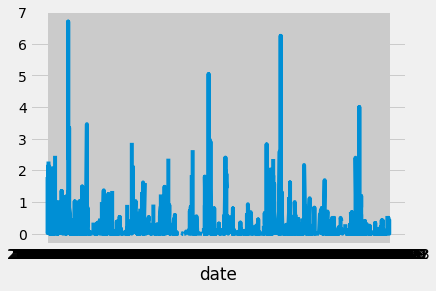

In [108]:
plt.plot(prec_data_df)
plt.xlabel("date")
plt.show()

In [109]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_data_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [85]:
# Design a query to calculate the total number stations in the dataset
for col1 in inspector.get_columns('Station'):
    print(col1)

station_data = session.query(Station.station).count()

print(f"A total of {station_data} stations exist.")

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
A total of 9 stations exist.


In [87]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_data_activity = session.query(Measurement.station, func.count(Measurement.station)) \
                                .group_by("station") \
                                .order_by(desc(func.count(Measurement.station)))
for station in station_data_activity:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [89]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_data_tob = session.query(Measurement.station, func.min(Measurement.tobs), \
                                 func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                                 .group_by("station") \
                                 .filter(Measurement.station == 'USC00519281')
for station in station_data_tob:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


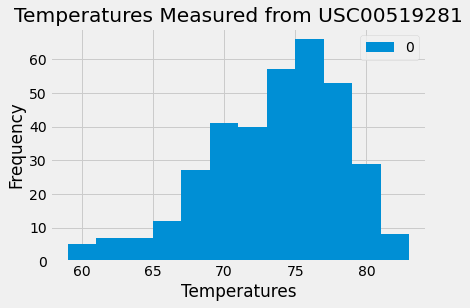

In [91]:
# Using the most active station id
station_data_mostTemps_12mo = session.query(Measurement.tobs) \
                                    .filter(Measurement.station == 'USC00519281') \
                                    .filter(Measurement.date <= max_date) \
                                    .filter(Measurement.date >= min_date)
station_data_mostTemps_12mo_df = pd.DataFrame(station_data_mostTemps_12mo)


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data_mostTemps_12mo_df.plot.hist(bins=12)
plt.title("Temperatures Measured from USC00519281")
plt.xlabel("Temperatures")
plt.ylabel("Frequency")
plt.show()

# Close session

In [92]:
# Close Session
session.close()